# Lstm 时间序列

In [39]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

import help as hp
from importlib import reload
reload(hp)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype= torch.float32

In [3]:
%matplotlib widget
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1
True


## 数据读取&预处理

In [ ]:
数据需要分割为，bacth 每个bacth是时间序列例如：100个时间序列 shape为(100,6)，分4个bacth，5-Time sequence，
那么第一个batch的 
index  [[0,1,2,3,4],[25,26,27,28,29],[50,51,52,53,54],[75,76,77,78,79]] 
shape为[4,5,6] #6 为向量的维度

In [52]:
data = pd.read_pickle('./Data/data.pkl')
data.shape

In [54]:
x = np.arange(data.shape[0])*0.01
y_sin = data.iloc[:,0].values
y_sincos = data.iloc[:,1].values
y_cos = data.iloc[:,2].values

In [62]:
y_cos.dtype

dtype('float32')

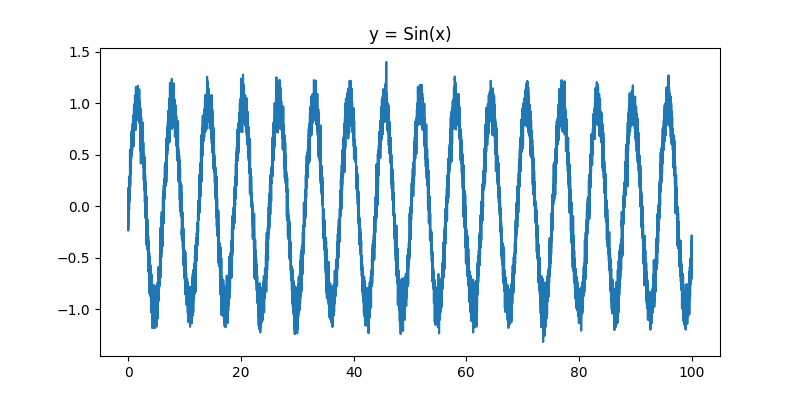

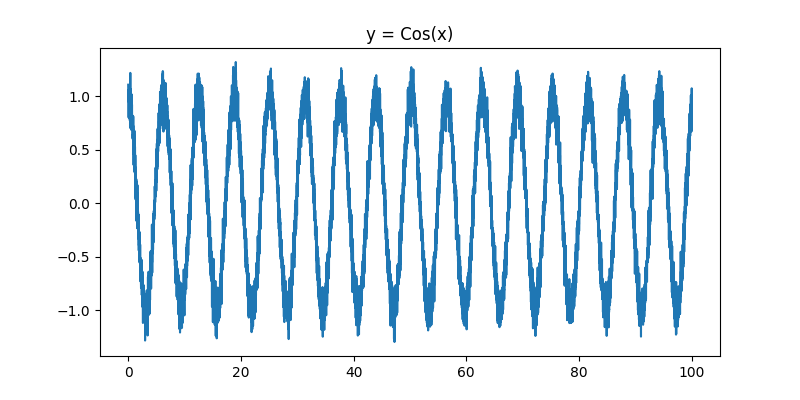

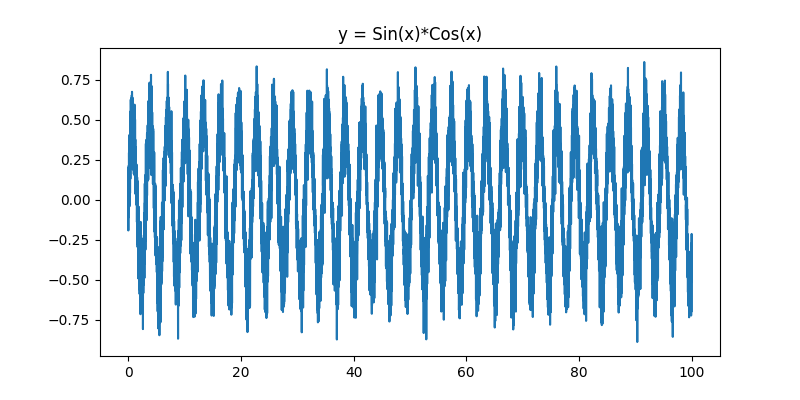

In [55]:
hp.Plt(x,y_sin).fig_size(8,4).plt_show(label = 'Sin(x)')
hp.Plt(x,y_cos).fig_size(8,4).plt_show(label = 'Cos(x)')
hp.Plt(x,y_sincos).fig_size(8,4).plt_show(label = 'Sin(x)*Cos(x)')

In [127]:
class Sampler:
    def __init__(self,data,batch_size = 10):
        self.data = data
        self.row, self.column = data.shape[0],data.shape[1]
        self.dtype = data.dtype
        self.batch_size = batch_size
        
    def transform_data(self):
        quotient, remainder = divmod(self.row, self.batch_size)
        if remainder != 0:
            return quotient+1,np.concatenate((self.data,np.zeros((self.batch_size-remainder,self.column),dtype = self.dtype )),axis=0)
        else:
            return quotient,self.data
        
    
    def gene_batch(self,T_seq = 10):
        quotient,data = self.transform_data()
        row,column = data.shape[0],data.shape[1]
        gene_index = np.empty(row,dtype=int) 
        gene_index_matrix = np.arange(row).reshape((self.batch_size,quotient))
        sum_index= 0
        for i in range(0,quotient,T_seq):
            batch_index_matrix = gene_index_matrix[:,i:i+T_seq]
            batch_index_matrix_list = batch_index_matrix.flatten()
            gene_index[sum_index:sum_index+batch_index_matrix_list.shape[0]]=batch_index_matrix_list
            sum_index += batch_index_matrix_list.shape[0]
        if sum_index!=row:
            raise RuntimeError("Generate new index error! Need Check!")
        batch_data = np.take(data,gene_index,axis=0)
        
        return batch_data







In [128]:
data_np = data.values
data_sampler = Sampler(data_np,batch_size = 10)
batch_data = data_sampler.gene_batch(T_seq = 10)

In [129]:
batch_data 

array([[-0.18807098, -0.10847952,  1.105828  ],
       [ 0.0338036 ,  0.0962373 ,  0.985181  ],
       [-0.2379235 , -0.06382605,  0.9521437 ],
       ...,
       [-0.9012206 ,  0.02240093,  0.02632581],
       [ 0.8184703 , -0.5000952 , -0.5105751 ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [ ]:
batch = 10
T_seq = 20
# dataloader batch = batch*T_seq

In [82]:
# 用作测试的随机生成数据，模型搭建阶段
data = torch.randn(100, 20, 6).to(device)
print(data.shape)
data_loader = DataLoader(data,batch_size=10, shuffle =False)

torch.Size([100, 20, 6])


In [84]:
for ite_data in data_loader:
    print(ite_data.shape)

torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])
torch.Size([10, 20, 6])


## 模型搭建Trucated Time LSTM


$$
p(x_1,x_2,\cdots, x_T) = p(x_T | x_{T-1}, x_{T-2}\cdots,x_1 )p(x_{T-1} |x_{T-2}, x_{T-2}\cdots,x_1 )\cdots p(x_1|x_0)
$$

### Code

In [135]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, stateful=False):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.stateful = stateful
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # 输入层到隐藏层的线性变换
            nn.Sigmoid(), 
            nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的线性变换
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


In [137]:
model = LSTMModel(input_size=6, hidden_size=64, output_size=6, num_layers=2, stateful=True).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
)


In [138]:
# 定义损失函数
criterion = nn.MSELoss()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [139]:

# 在训练循环中使用模型
for epoch in range(10):
    for ite_data in data_loader:
        optimizer.zero_grad()
        outputs = model(ite_data)
        loss = criterion(outputs,ite_data)
        loss.backward()
        optimizer.step()
    # 在每个epoch结束时重置隐藏状态
    

#### Trian

#### Test

#### Plot

## Other

In [53]:
import torch
import torch.nn as nn

# 创建一个 LSTM 模型
input_size = 6
hidden_size = 64
num_layers = 2

lstm = nn.LSTM(input_size, hidden_size, num_layers)

# 获取 LSTM 层的内部参数
for name, param in lstm.named_parameters():
    print(name, param.shape)  # 打印参数名称和形状
    if 'weight' in name:
        print(param)  

weight_ih_l0 torch.Size([256, 6])
Parameter containing:
tensor([[ 0.0190,  0.0466,  0.0939, -0.1031, -0.0823, -0.0815],
        [-0.1227,  0.1120, -0.0202,  0.0612, -0.0999,  0.0019],
        [ 0.0784, -0.0855, -0.0059, -0.1212, -0.1186,  0.0731],
        ...,
        [ 0.1211, -0.1246,  0.0883, -0.0198, -0.0063, -0.1188],
        [ 0.0736, -0.0348, -0.0507, -0.0438, -0.0813, -0.0166],
        [ 0.0602,  0.0599,  0.0517, -0.0870, -0.1011,  0.0219]],
       requires_grad=True)
weight_hh_l0 torch.Size([256, 64])
Parameter containing:
tensor([[ 0.0712,  0.0581, -0.0472,  ..., -0.0971,  0.0308, -0.0876],
        [-0.0146, -0.0151, -0.0565,  ..., -0.0939, -0.0738, -0.1106],
        [ 0.0443,  0.0448, -0.0205,  ...,  0.0342,  0.0542,  0.0120],
        ...,
        [-0.0541, -0.1113,  0.0172,  ..., -0.0155, -0.0938, -0.0826],
        [ 0.0789,  0.0968,  0.0339,  ..., -0.0500, -0.1214,  0.0398],
        [-0.0329,  0.0444,  0.0413,  ..., -0.1051, -0.0540,  0.0395]],
       requires_grad=True)
b

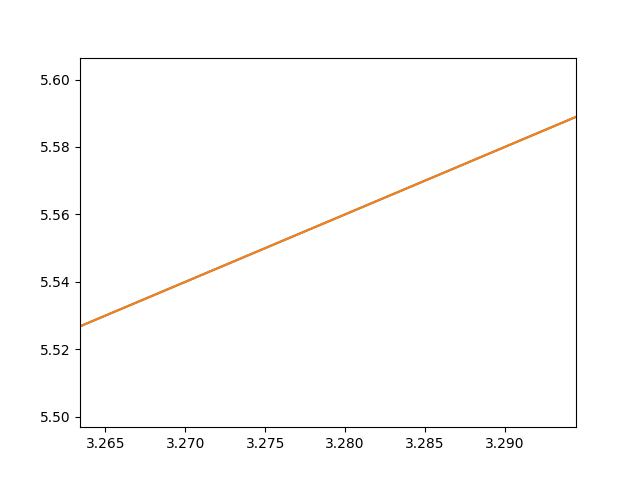

In [54]:

x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]
plt.plot(x, y)
plt.show()

In [ ]:
 哎查处